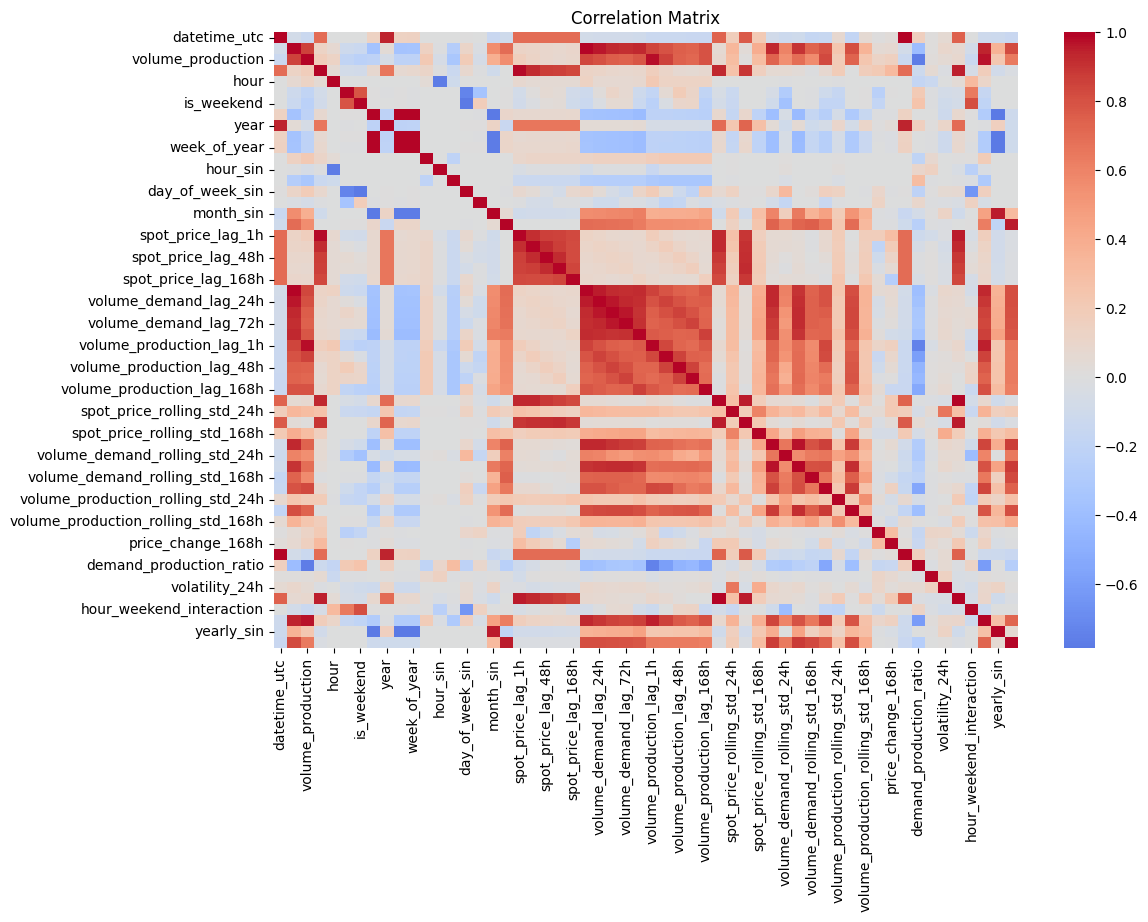

[flaml.automl.logger: 10-27 18:22:37] {1728} INFO - task = ts_forecast
[flaml.automl.logger: 10-27 18:22:37] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-27 18:22:37] {1838} INFO - Minimizing error metric: mae
[flaml.automl.logger: 10-27 18:22:37] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'prophet', 'arima', 'sarimax', 'holt-winters']
[flaml.automl.logger: 10-27 18:22:37] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-27 18:23:49] {2393} INFO - Estimated sufficient time budget=722214s. Estimated necessary time budget=722s.
[flaml.automl.logger: 10-27 18:23:49] {2442} INFO -  at 72.6s,	estimator lgbm's best error=19.6178,	best estimator lgbm's best error=19.6178
[flaml.automl.logger: 10-27 18:23:49] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-27 18:28:43] {2442} INFO -  at 366.2s,	estimator lgbm's best error=19.6178,	best estimator lgbm's best erro

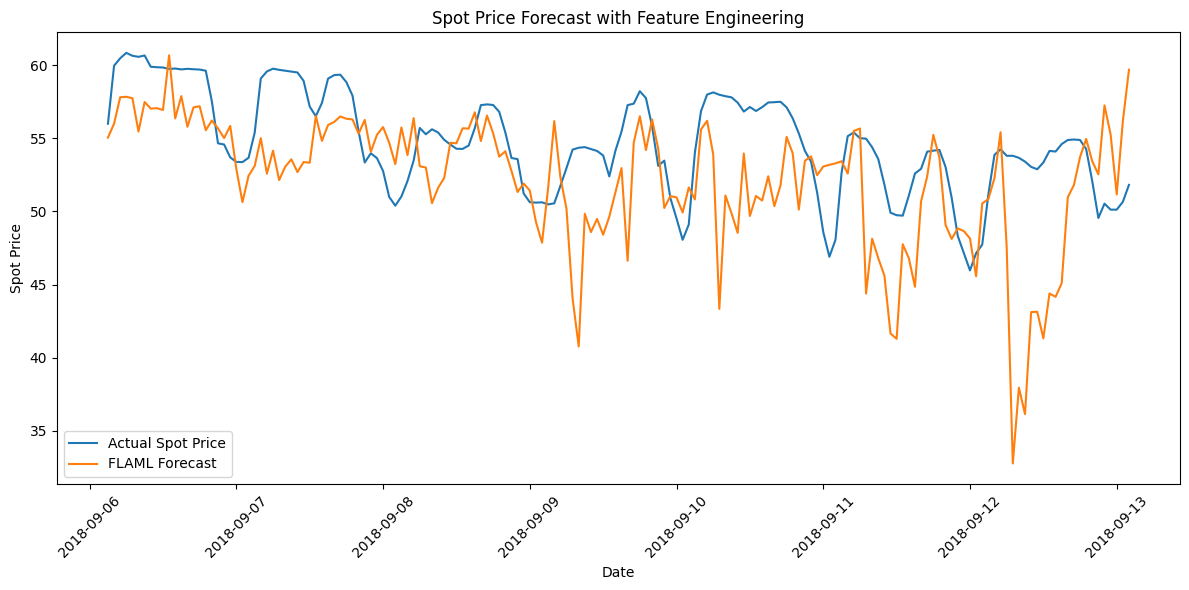

In [1]:
''' multivariate time series forecasting dataset'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess the dataset
df = pd.read_csv('Datasets/data_NO2.csv', sep=';', parse_dates=['datetime_utc'])
df = df.set_index('datetime_utc')
df.index = df.index.tz_localize(None)
df = df.resample('H').ffill()
df = df.bfill()
df = df.reset_index()

# Add time-based features
df['hour'] = df['datetime_utc'].dt.hour
df['day_of_week'] = df['datetime_utc'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['datetime_utc'].dt.month
df['year'] = df['datetime_utc'].dt.year
df['day_of_year'] = df['datetime_utc'].dt.dayofyear
df['week_of_year'] = df['datetime_utc'].dt.isocalendar().week
df['is_peak_hour'] = df['hour'].isin([6, 7, 8, 16, 17, 18]).astype(int)

# Add cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add lag features
for col in ['spot_price', 'volume_demand', 'volume_production']:
    for lag in [1, 24, 48, 72, 168]:
        df[f'{col}_lag_{lag}h'] = df[col].shift(lag)

# Add rolling statistics
for col in ['spot_price', 'volume_demand', 'volume_production']:
    for window in [24, 168]:
        df[f'{col}_rolling_mean_{window}h'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}h'] = df[col].rolling(window=window).std()

# Add additional features
df['price_change_24h'] = df['spot_price'] - df['spot_price_lag_24h']
df['price_change_168h'] = df['spot_price'] - df['spot_price_lag_168h']
df['days_since_start'] = (df['datetime_utc'] - df['datetime_utc'].min()).dt.total_seconds() / (24 * 3600)
df['demand_production_ratio'] = df['volume_demand'] / df['volume_production']
df['returns'] = df['spot_price'].pct_change()
df['volatility_24h'] = df['returns'].rolling(window=24).std()
df['price_ewma'] = df['spot_price'].ewm(span=24, adjust=False).mean()
df['hour_weekend_interaction'] = df['hour'] * df['is_weekend']
df['demand_production_interaction'] = df['volume_demand'] * df['volume_production']
df['yearly_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['yearly_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# Drop rows with NaN values
df.dropna(inplace=True)

# Correlation matrix with no numbers using seaborn
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Split data into train and test
num_samples = df.shape[0]
time_horizon = 168  # Predict for the next 168 hours (1 week)
split_idx = num_samples - time_horizon
train_df = df[:split_idx]
test_df = df[split_idx:]

# Select features for testing (excluding datetime_utc and target variable)
feature_cols = [col for col in df.columns if col not in ['datetime_utc', 'spot_price']]
X_test = test_df[['datetime_utc'] + feature_cols]
y_test = test_df['spot_price']

# Initialize AutoML
automl = AutoML()

# Configure settings
settings = {
    "time_budget": 1000,  # increased time budget due to more features
    "metric": "mae",
    "task": "ts_forecast",
    "log_file_name": "spot_price_forecast.log",
    "eval_method": "holdout",
    "log_type": "all",
    "label": "spot_price",
    "period": time_horizon,
    "estimator_list": ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'prophet', 'arima', 'sarimax', 'holt-winters'],
}

# Fit the model
automl.fit(dataframe=train_df, **settings)

# Make predictions and evaluate
y_pred = automl.predict(X_test)
mae = sklearn_metric_loss_score('mae', y_true=y_test, y_predict=y_pred)
print('MAE =', mae)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_test["datetime_utc"], y_test, label="Actual Spot Price")
plt.plot(X_test["datetime_utc"], y_pred, label="FLAML Forecast")
plt.xlabel("Date")
plt.ylabel("Spot Price")
plt.title("Spot Price Forecast with Feature Engineering")
plt.legend()    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
import os
os.system('say "Wallah min bror! Din maskinlæringsmodell er klar. In god may your predictions be goated and the MAE low!"')

0